# Drugstore Location Selection System

Select 5 nearby drugstores for each student
with distribution for realism.

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import haversine_distances
from sklearn.preprocessing import StandardScaler
import warnings
import os
warnings.filterwarnings('ignore')

In [2]:
dir = '/Users/suparvitp/Programming/internshipPlacementSelectionSystem'
drugstore_locations = os.path.join(dir,'drugstore_locations.csv')
student_list = os.path.join(dir,'rxcu85_list_cleaned_hashed.csv')

# Load data
drugstore_df = pd.read_csv(drugstore_locations)
student_df = pd.read_csv(student_list)

print("Drugstore DataFrame shape:", drugstore_df.shape)
print("Student DataFrame shape:", student_df.shape)
print("\nDrugstore columns:", drugstore_df.columns.tolist())
print("Student columns:", student_df.columns.tolist())
print("\nFirst few drugstores:")
print(drugstore_df[['code', 'branch', 'latitude', 'longitude']].head())

Drugstore DataFrame shape: (245, 10)
Student DataFrame shape: (134, 4)

Drugstore columns: ['Unnamed: 0', 'code', 'branch', 'address', 'sex_require1', 'seat1', 'sex_require2', 'seat2', 'latitude', 'longitude']
Student columns: ['student_name', 'student_id', 'sex', 'shift']

First few drugstores:
    code                   branch   latitude   longitude
0  CEN01      6 สโมสรวัฒนธรรมหญิง  13.760206  100.516908
1  CEN02  7 บุญมี ปุรุราชรังสรรค์  13.680804  100.530974
2  CEN03             19 วงศ์สว่าง  13.827239  100.526440
3  CEN04     20 ป้อมปราบศัตรูพ่าย  13.759351  100.512295
4  CEN05              23 สี่พระยา  13.730659  100.520309


## Algorithm Overview

### Selection Steps:

1. **Anchor Selection**: For each student, randomly select one location as "home".
2. **Radius Search**: Search for locations within a 5km radius (adjustable).
3. **Weighted Random Selection**: Select 5 locations from that group, where:
   - Closer = Higher chance of being selected (weighted probability).
   - Not necessarily the 5 closest, for diversity.
   - If < 5 locations in radius, expand the radius.

In [3]:
def calculate_haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate Haversine distance between two points (unit: km)
    """
    # Convert degrees to radians
    coords1 = np.array([[lat1, lon1]]) * np.pi / 180
    coords2 = np.array([[lat2, lon2]]) * np.pi / 180
    
    # Calculate Haversine distance (unit: radians)
    dist = haversine_distances(coords1, coords2)[0, 0]
    
    # Convert to km (Earth radius = 6371 km)
    return dist * 6371


def select_nearby_drugstores(student_idx, anchor_radius=5.0, expand_radius=1.5, 
                             min_nearby=5, target_count=5, random_seed=None):
    """
    Select 5 nearby drugstores for each student
    
    Parameters:
    -----------
    student_idx : int
        Student index (used as seed for realism)
    anchor_radius : float
        Search radius in km (default 5 km)
    expand_radius : float
        Expand radius by expand_radius * anchor_radius if locations < min_nearby
    min_nearby : int
        Minimum number of locations required
    target_count : int
        Number of locations to select (default 5)
    random_seed : int
        Seed for random state
        
    Returns:
    --------
    list : List of 5 location codes (rank1, rank2, ..., rank5)
    """
    if random_seed is None:
        random_seed = student_idx
    
    np.random.seed(random_seed)
    
    # ============ STEP 1: Randomly Select Anchor Drugstore ============
    anchor_idx = np.random.randint(0, len(drugstore_df))
    anchor_lat = drugstore_df.iloc[anchor_idx]['latitude']
    anchor_lon = drugstore_df.iloc[anchor_idx]['longitude']
    anchor_code = drugstore_df.iloc[anchor_idx]['code']
    
    # ============ STEP 2: Search for locations in radius ============
    current_radius = anchor_radius
    nearby_candidates = []
    max_iterations = 15  # Prevent infinite loop
    iteration = 0
    
    while len(nearby_candidates) < min_nearby and iteration < max_iterations:
        nearby_candidates = []
        iteration += 1
        
        for idx, row in drugstore_df.iterrows():
            if idx == anchor_idx:  # Skip self
                continue
                
            distance = calculate_haversine_distance(
                anchor_lat, anchor_lon, 
                row['latitude'], row['longitude']
            )
            
            if distance <= current_radius:
                nearby_candidates.append({
                    'idx': idx,
                    'code': row['code'],
                    'distance': distance,
                    'latitude': row['latitude'],
                    'longitude': row['longitude']
                })
        
        if len(nearby_candidates) < min_nearby:
            current_radius *= expand_radius
    
    # If still not enough, use all
    if len(nearby_candidates) == 0:
        nearby_candidates = []
        for idx, row in drugstore_df.iterrows():
            if idx != anchor_idx:
                distance = calculate_haversine_distance(
                    anchor_lat, anchor_lon, 
                    row['latitude'], row['longitude']
                )
                nearby_candidates.append({
                    'idx': idx,
                    'code': row['code'],
                    'distance': distance,
                    'latitude': row['latitude'],
                    'longitude': row['longitude']
                })
    
    nearby_candidates = sorted(nearby_candidates, key=lambda x: x['distance'])
    
    # ============ STEP 3: Weighted Random Selection ============
    distances = np.array([c['distance'] for c in nearby_candidates])
    
    # Create weights so closer locations have higher chance
    if len(distances) > 0:
        max_dist = distances.max()
        min_dist = distances.min()
        
        # Create curve: Closest = 1.0, Farthest = 0.3
        if max_dist > min_dist:
            normalized_dist = (distances - min_dist) / (max_dist - min_dist)
            weights = 1.0 - 0.7 * normalized_dist  # 1.0 down to 0.3
        else:
            weights = np.ones_like(distances)
        
        weights = weights / weights.sum()  # normalize to probability distribution
    else:
        return [anchor_code]  # fallback if not found
    
    # Select 5 locations (unique)
    num_to_select = min(target_count, len(nearby_candidates))
    selected_indices = np.random.choice(
        len(nearby_candidates), 
        size=num_to_select, 
        replace=False, 
        p=weights
    )
    
    selected = [nearby_candidates[i]['code'] for i in selected_indices]
    
    return selected


print("Function ready (Updated)")

Function ready (Updated)


In [4]:
def process_all_students(student_df, drugstore_df, 
                        anchor_radius=5.0, 
                        expand_radius=1.5,
                        random_seed_base=None):
    """
    Process for all students
    
    Parameters:
    -----------
    student_df : DataFrame
        Student data
    drugstore_df : DataFrame
        Drugstore data
    anchor_radius : float
        Initial search radius (km)
    expand_radius : float
        Multiplier for expanding radius
    random_seed_base : int
        Base seed for reproducibility
        
    Returns:
    --------
    DataFrame : student_df with rank1-rank5 columns
    """
    result_df = student_df.copy()
    
    # Add rank1 to rank5 columns
    for rank in range(1, 6):
        result_df[f'rank{rank}'] = ''
    
    print(f"Processing {len(student_df)} students...")
    
    for idx, student in student_df.iterrows():
        if (idx + 1) % 20 == 0:
            print(f"   Processed {idx + 1}/{len(student_df)}")
        
        # Select locations for this student
        seed = (random_seed_base or 42) + idx
        selected_codes = select_nearby_drugstores(
            student_idx=idx,
            anchor_radius=anchor_radius,
            expand_radius=expand_radius,
            random_seed=seed
        )
        
        # Fill into DataFrame
        for rank, code in enumerate(selected_codes, 1):
            result_df.at[idx, f'rank{rank}'] = code
    
    print(f"Processing complete!")
    return result_df


# ============ Run Processing ============
result_df = process_all_students(
    student_df, 
    drugstore_df,
    anchor_radius=5.0,      # 5 km
    expand_radius=1.5,      # Expand 50% if needed
    random_seed_base=42
)

print("\nResults:")
print(result_df[['student_id', 'rank1', 'rank2', 'rank3', 'rank4', 'rank5']].head(10))

Processing 134 students...
   Processed 20/134
   Processed 40/134
   Processed 60/134
   Processed 80/134
   Processed 100/134
   Processed 120/134
Processing complete!

Results:
   student_id  rank1  rank2  rank3  rank4  rank5
0  6630002133  FCN49  FCN44  PUR45  FCN45  FCN54
1  6630003833  FCN62  FCN60  FCN61  FCN64  FCN59
2  6630004433  BTS05  HPT01  BTS20  BTS14  BTS12
3  6630006733  FCN68  FCN55  PUR04  FCN67  FCN66
4  6630008033  FCN41  FCN32  CEN03  BTS15  FCN31
5  6630009633  BTS17  CEN06  BKK19  FCN40  FCN84
6  6630010133  BTS14  BTS11  BKK37  BKK02  FCN96
7  6630011833  FCN21  FCN22  PUR49  FCN24  PUR46
8  6630013033  FCN94  BKK02  BTS21  BTS27  FCN30
9  6630014733  BKK11  CEN09  BKK38  BKK04  BKK26


## Analysis & Validation

Check the quality of the results:

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Circle
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 12)
plt.rcParams['font.size'] = 10

Saved graph: drugstore_analysis.png


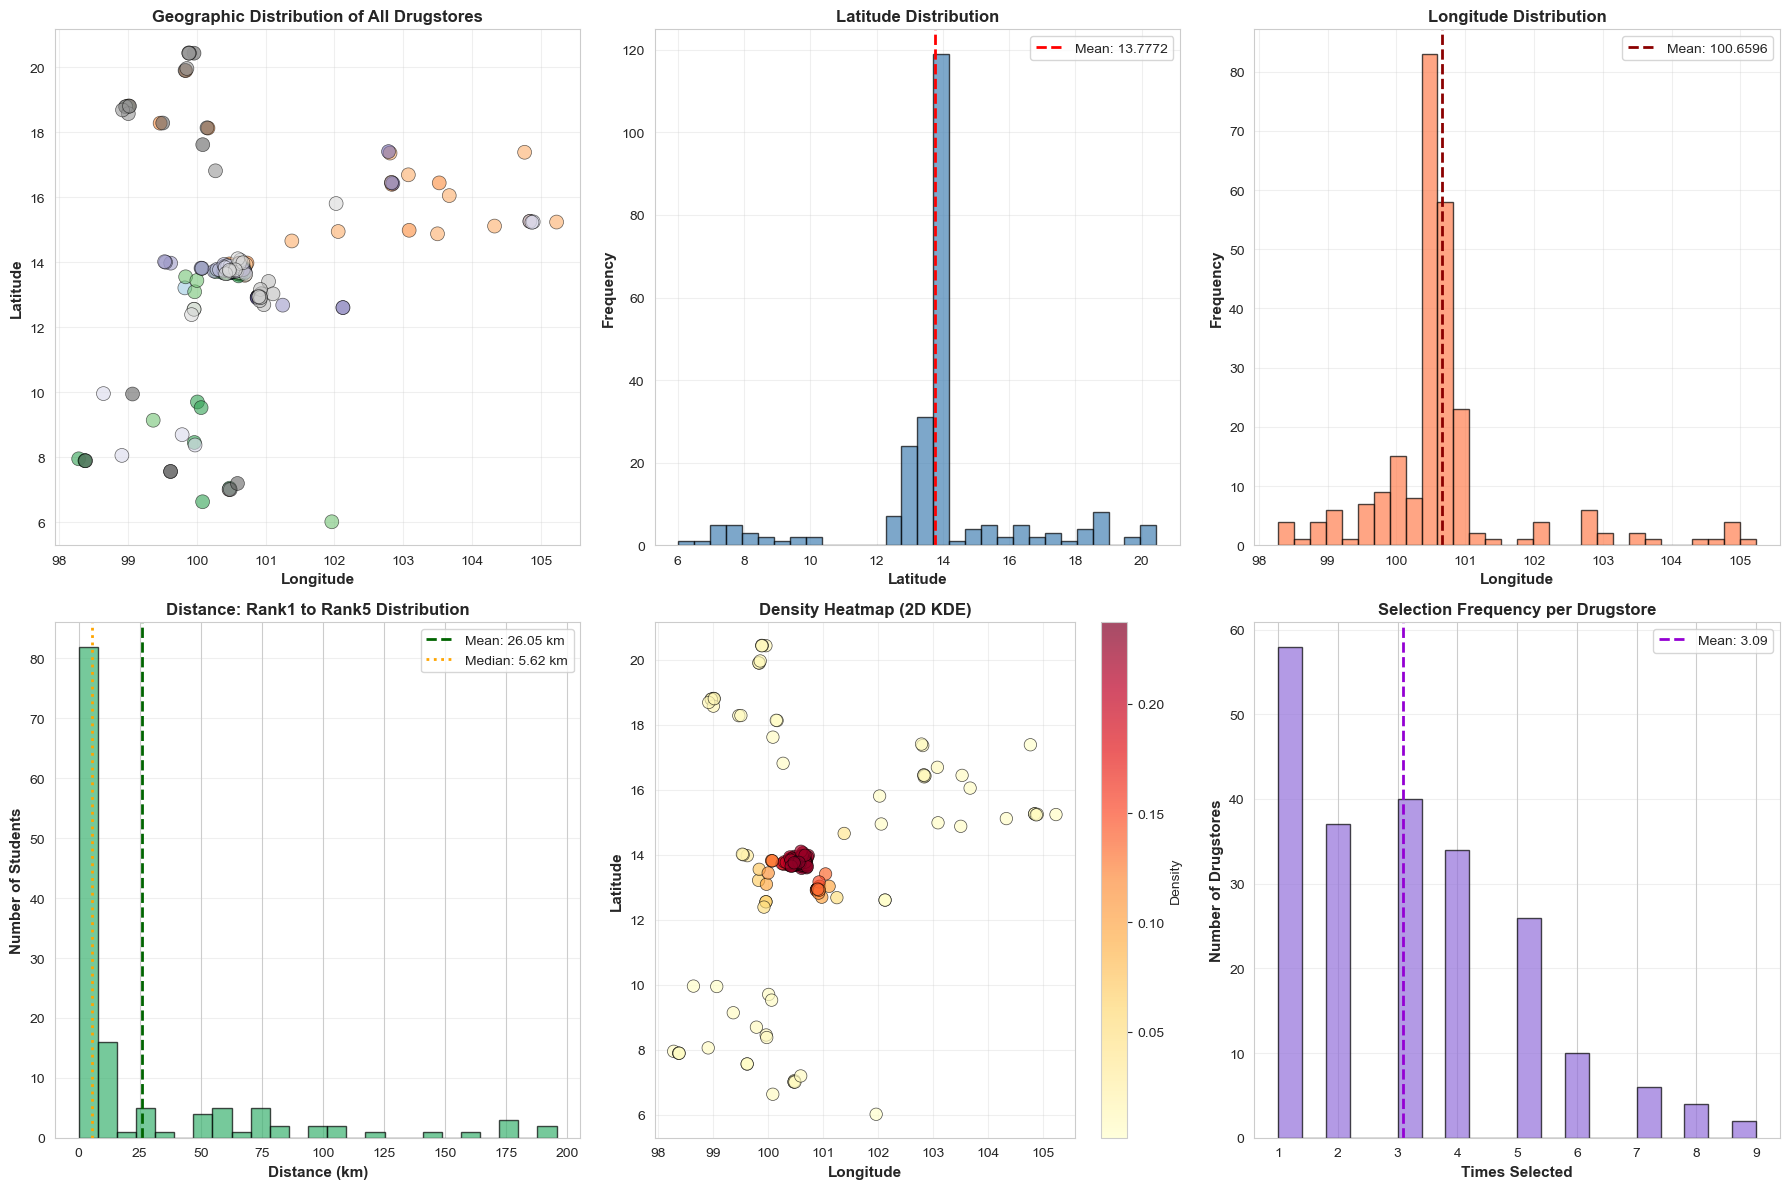

In [6]:
def visualize_drugstore_locations():
    """
    Analyze and visualize drugstore locations and distribution
    """
    fig = plt.figure(figsize=(18, 12))
    
    # ============ 1. Geographic Distribution - Scatter Plot ============
    ax1 = plt.subplot(2, 3, 1)
    scatter = ax1.scatter(drugstore_df['longitude'], drugstore_df['latitude'], 
                         c=range(len(drugstore_df)), cmap='tab20c', 
                         s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
    ax1.set_xlabel('Longitude', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Latitude', fontsize=11, fontweight='bold')
    ax1.set_title('Geographic Distribution of All Drugstores', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # ============ 2. Latitude Distribution ============
    ax2 = plt.subplot(2, 3, 2)
    ax2.hist(drugstore_df['latitude'], bins=30, color='steelblue', alpha=0.7, edgecolor='black')
    ax2.axvline(drugstore_df['latitude'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {drugstore_df["latitude"].mean():.4f}')
    ax2.set_xlabel('Latitude', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Frequency', fontsize=11, fontweight='bold')
    ax2.set_title('Latitude Distribution', fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # ============ 3. Longitude Distribution ============
    ax3 = plt.subplot(2, 3, 3)
    ax3.hist(drugstore_df['longitude'], bins=30, color='coral', alpha=0.7, edgecolor='black')
    ax3.axvline(drugstore_df['longitude'].mean(), color='darkred', linestyle='--', linewidth=2, label=f'Mean: {drugstore_df["longitude"].mean():.4f}')
    ax3.set_xlabel('Longitude', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Frequency', fontsize=11, fontweight='bold')
    ax3.set_title('Longitude Distribution', fontsize=12, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # ============ 4. Distance from Rank1 to Rank5 Distribution ============
    ax4 = plt.subplot(2, 3, 4)
    all_distances = []
    
    for idx, row in result_df.iterrows():
        ranks = [row[f'rank{i}'] for i in range(1, 6)]
        ranks = [r for r in ranks if r != '']
        
        if len(ranks) >= 2:
            coords = []
            for code in ranks:
                drug_row = drugstore_df[drugstore_df['code'] == code]
                if len(drug_row) > 0:
                    coords.append({
                        'lat': drug_row.iloc[0]['latitude'],
                        'lon': drug_row.iloc[0]['longitude']
                    })
            
            if len(coords) >= 2:
                dist = calculate_haversine_distance(
                    coords[0]['lat'], coords[0]['lon'],
                    coords[-1]['lat'], coords[-1]['lon']
                )
                all_distances.append(dist)
    
    ax4.hist(all_distances, bins=25, color='mediumseagreen', alpha=0.7, edgecolor='black')
    ax4.axvline(np.mean(all_distances), color='darkgreen', linestyle='--', linewidth=2, label=f'Mean: {np.mean(all_distances):.2f} km')
    ax4.axvline(np.median(all_distances), color='orange', linestyle=':', linewidth=2, label=f'Median: {np.median(all_distances):.2f} km')
    ax4.set_xlabel('Distance (km)', fontsize=11, fontweight='bold')
    ax4.set_ylabel('Number of Students', fontsize=11, fontweight='bold')
    ax4.set_title('Distance: Rank1 to Rank5 Distribution', fontsize=12, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3, axis='y')
    
    # ============ 5. Density Heatmap (2D KDE) ============
    ax5 = plt.subplot(2, 3, 5)
    from scipy.stats import gaussian_kde
    
    xy = np.vstack([drugstore_df['longitude'], drugstore_df['latitude']])
    z = gaussian_kde(xy)(xy)
    
    scatter2 = ax5.scatter(drugstore_df['longitude'], drugstore_df['latitude'], 
                          c=z, s=80, cmap='YlOrRd', alpha=0.7, edgecolors='black', linewidth=0.5)
    ax5.set_xlabel('Longitude', fontsize=11, fontweight='bold')
    ax5.set_ylabel('Latitude', fontsize=11, fontweight='bold')
    ax5.set_title('Density Heatmap (2D KDE)', fontsize=12, fontweight='bold')
    plt.colorbar(scatter2, ax=ax5, label='Density')
    ax5.grid(True, alpha=0.3)
    
    # ============ 6. Selection Count per Drugstore ============
    ax6 = plt.subplot(2, 3, 6)
    
    # Count how many times each location is selected
    selection_count = {}
    for idx, row in result_df.iterrows():
        for i in range(1, 6):
            code = row[f'rank{i}']
            if code != '':
                selection_count[code] = selection_count.get(code, 0) + 1
    
    counts = sorted(selection_count.values(), reverse=True)
    ax6.hist(counts, bins=20, color='mediumpurple', alpha=0.7, edgecolor='black')
    ax6.axvline(np.mean(counts), color='darkviolet', linestyle='--', linewidth=2, label=f'Mean: {np.mean(counts):.2f}')
    ax6.set_xlabel('Times Selected', fontsize=11, fontweight='bold')
    ax6.set_ylabel('Number of Drugstores', fontsize=11, fontweight='bold')
    ax6.set_title('Selection Frequency per Drugstore', fontsize=12, fontweight='bold')
    ax6.legend()
    ax6.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(os.path.join(dir, 'drugstore_analysis.png'), dpi=300, bbox_inches='tight')
    print("Saved graph: drugstore_analysis.png")
    plt.show()

visualize_drugstore_locations()

Saved graph: sample_students_selection.png


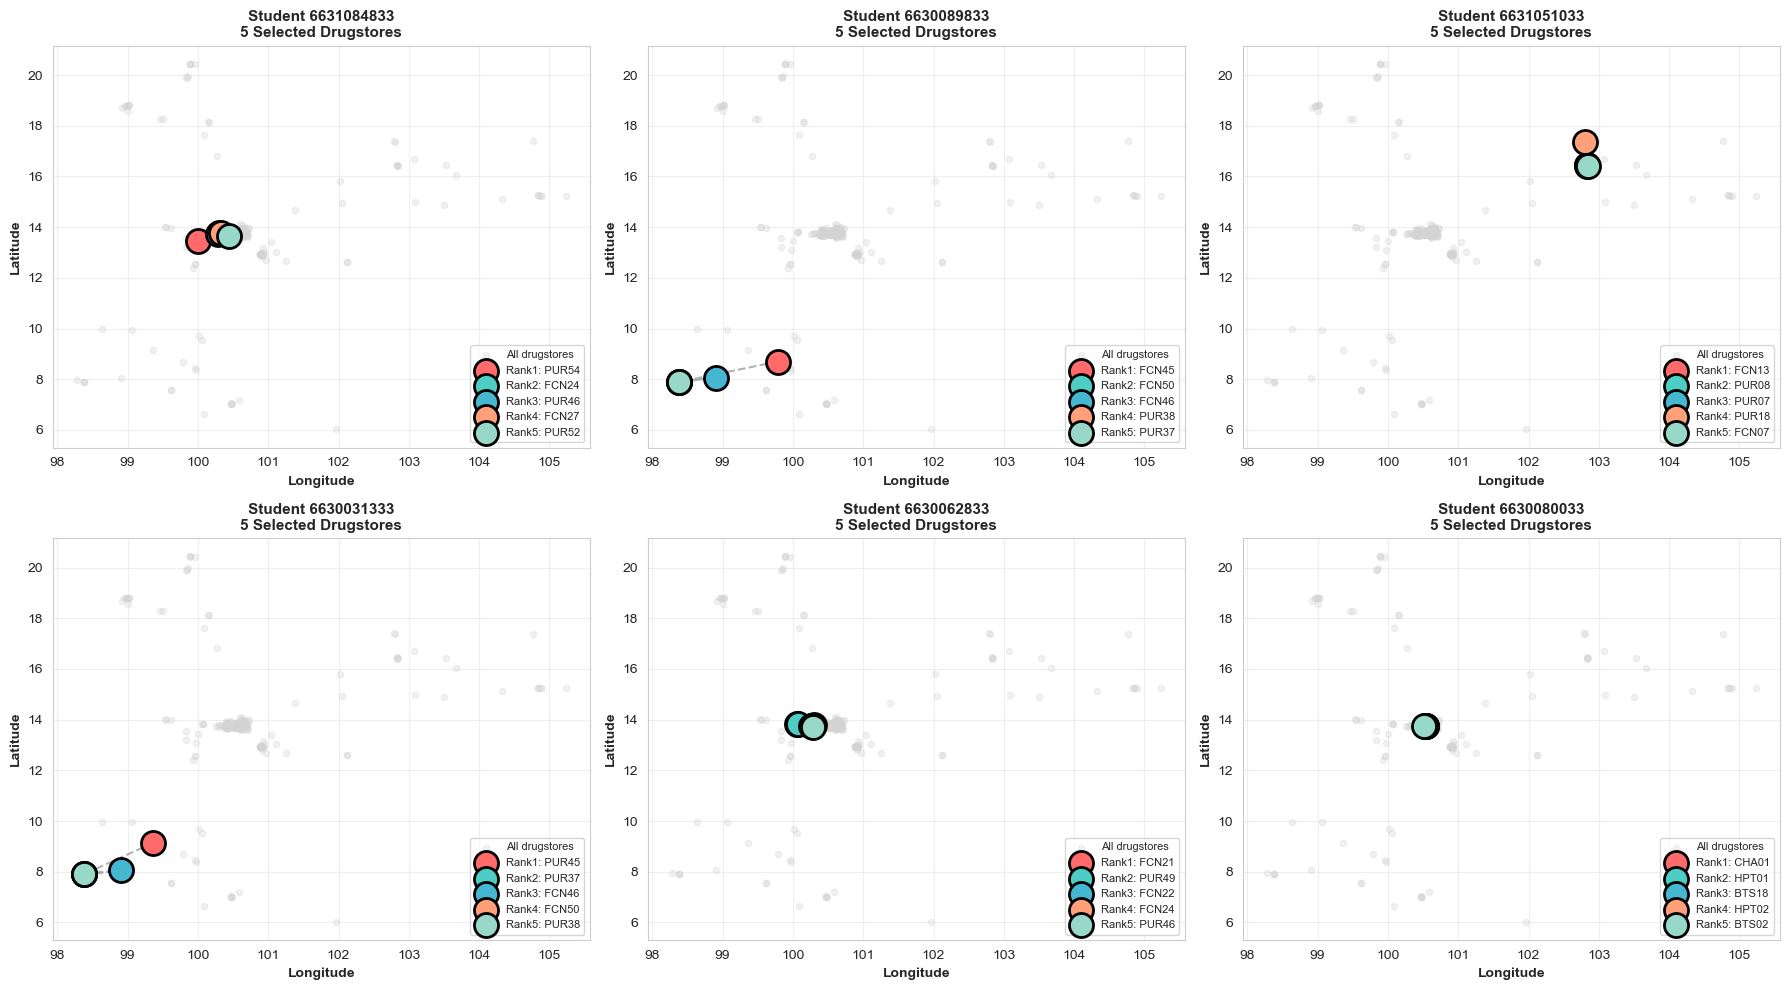

In [7]:
def visualize_sample_students(num_students=6):
    """
    Visualize sample students
    Showing 5 selected locations and connections for each student
    """
    np.random.seed(42)
    sample_indices = np.random.choice(len(result_df), size=num_students, replace=False)
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    for plot_idx, student_idx in enumerate(sample_indices):
        ax = axes[plot_idx]
        
        student_row = result_df.iloc[student_idx]
        student_id = student_row['student_id']
        
        # Get 5 locations
        ranks = [student_row[f'rank{i}'] for i in range(1, 6)]
        ranks = [r for r in ranks if r != '']
        
        # Get coordinates of 5 locations
        selected_coords = []
        for rank_num, code in enumerate(ranks, 1):
            drug_row = drugstore_df[drugstore_df['code'] == code]
            if len(drug_row) > 0:
                selected_coords.append({
                    'rank': rank_num,
                    'code': code,
                    'lat': drug_row.iloc[0]['latitude'],
                    'lon': drug_row.iloc[0]['longitude']
                })
        
        # Plot all drugstores (light)
        ax.scatter(drugstore_df['longitude'], drugstore_df['latitude'], 
                  c='lightgray', s=20, alpha=0.3, label='All drugstores')
        
        # Plot 5 selected locations
        colors_rank = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']
        for coord in selected_coords:
            ax.scatter(coord['lon'], coord['lat'], 
                      c=colors_rank[coord['rank']-1], s=300, 
                      marker='o', edgecolors='black', linewidth=2,
                      label=f"Rank{coord['rank']}: {coord['code']}", zorder=5)
        
        # Connect from rank1 to rank5
        if len(selected_coords) > 1:
            lons = [c['lon'] for c in selected_coords]
            lats = [c['lat'] for c in selected_coords]
            ax.plot(lons, lats, 'k--', alpha=0.3, linewidth=1.5, zorder=1)
        
        ax.set_xlabel('Longitude', fontsize=10, fontweight='bold')
        ax.set_ylabel('Latitude', fontsize=10, fontweight='bold')
        ax.set_title(f"Student {student_id}\n5 Selected Drugstores", fontsize=11, fontweight='bold')
        ax.legend(fontsize=8, loc='best')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(dir, 'sample_students_selection.png'), dpi=300, bbox_inches='tight')
    print("Saved graph: sample_students_selection.png")
    plt.show()

visualize_sample_students(6)

Saved graph: detailed_analysis.png


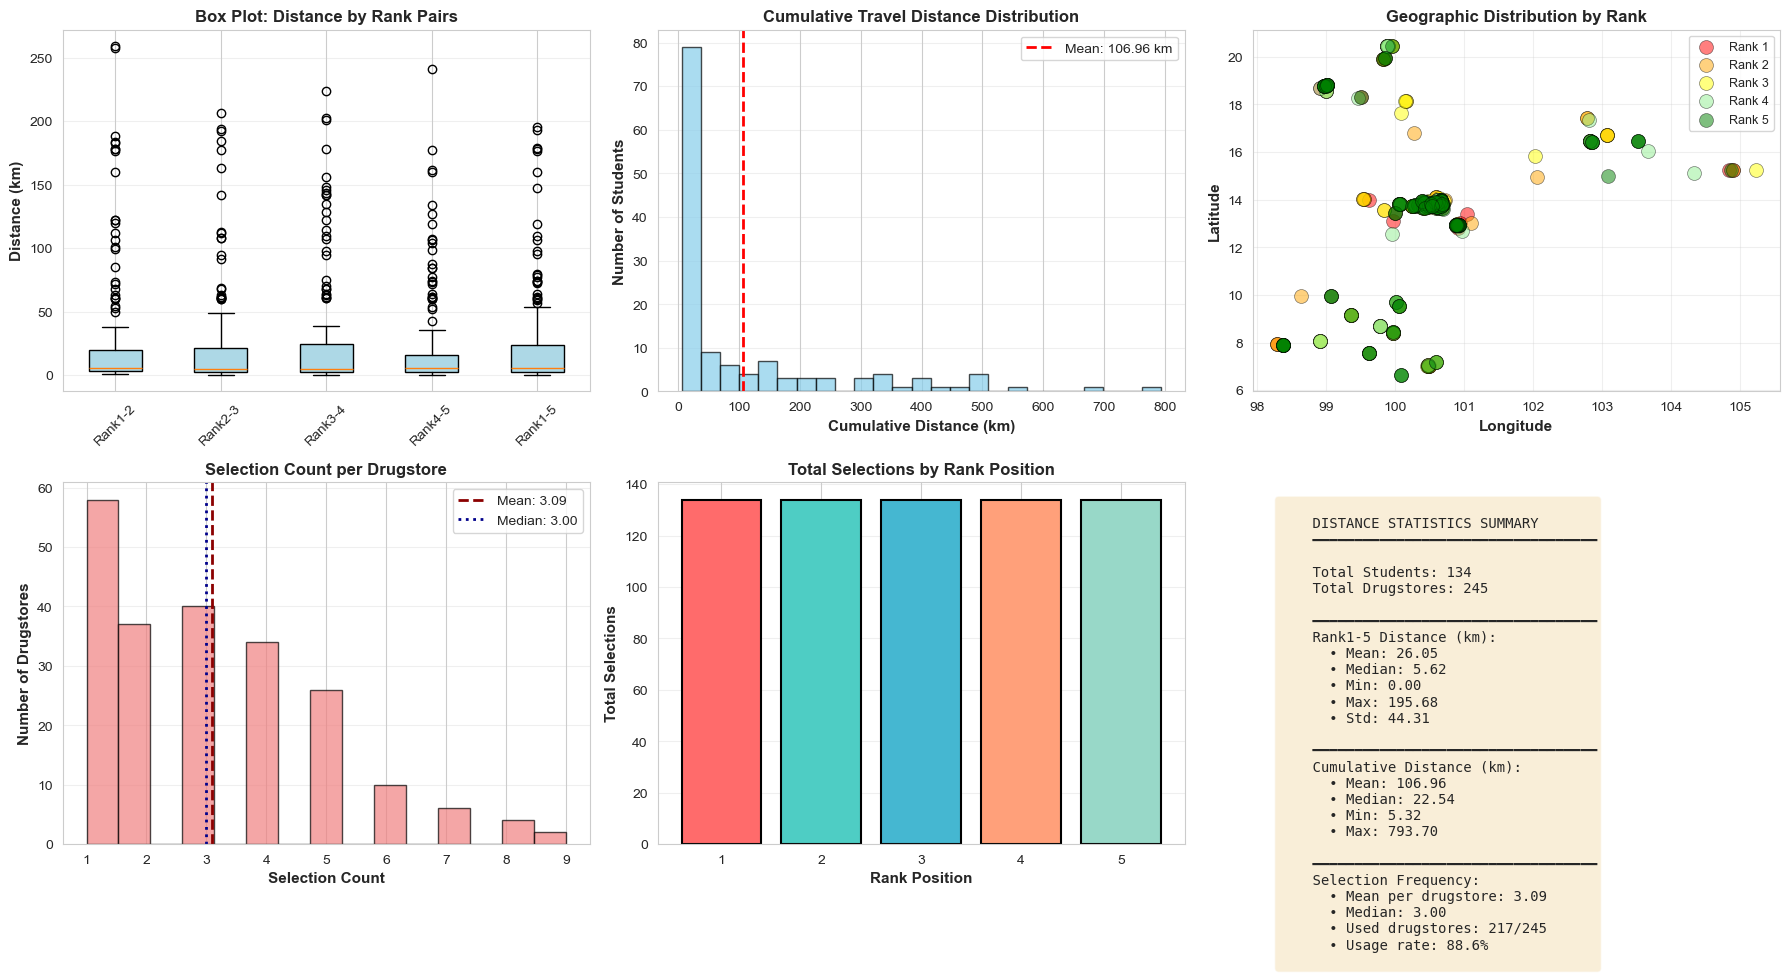

In [8]:
def visualize_detailed_analysis():
    """
    Show additional visualization for detailed analysis
    """
    fig = plt.figure(figsize=(18, 10))
    
    # ============ Compute all distances first ============
    all_distances_computed = []
    cumulative_distances_computed = []
    
    for idx, row in result_df.iterrows():
        ranks = [row[f'rank{i}'] for i in range(1, 6)]
        ranks = [r for r in ranks if r != '']
        
        coords = []
        for code in ranks:
            drug_row = drugstore_df[drugstore_df['code'] == code]
            if len(drug_row) > 0:
                coords.append({
                    'lat': drug_row.iloc[0]['latitude'],
                    'lon': drug_row.iloc[0]['longitude']
                })
        
        if len(coords) >= 2:
            dist = calculate_haversine_distance(
                coords[0]['lat'], coords[0]['lon'],
                coords[-1]['lat'], coords[-1]['lon']
            )
            all_distances_computed.append(dist)
        
        total_dist = 0
        for i in range(len(coords)-1):
            dist = calculate_haversine_distance(
                coords[i]['lat'], coords[i]['lon'],
                coords[i+1]['lat'], coords[i+1]['lon']
            )
            total_dist += dist
        cumulative_distances_computed.append(total_dist)
    
    # ============ 1. Box Plot: Distance Statistics ============
    ax1 = plt.subplot(2, 3, 1)
    
    # Calculate distance for each rank pair
    rank_distances = {
        'Rank1-2': [], 'Rank2-3': [], 'Rank3-4': [], 'Rank4-5': [], 'Rank1-5': []
    }
    
    for idx, row in result_df.iterrows():
        ranks = [row[f'rank{i}'] for i in range(1, 6)]
        ranks = [r for r in ranks if r != '']
        
        coords = []
        for code in ranks:
            drug_row = drugstore_df[drugstore_df['code'] == code]
            if len(drug_row) > 0:
                coords.append({
                    'lat': drug_row.iloc[0]['latitude'],
                    'lon': drug_row.iloc[0]['longitude']
                })
        
        # Distance between consecutive ranks
        for i in range(len(coords)-1):
            dist = calculate_haversine_distance(
                coords[i]['lat'], coords[i]['lon'],
                coords[i+1]['lat'], coords[i+1]['lon']
            )
            rank_distances[f'Rank{i+1}-{i+2}'].append(dist)
        
        # Distance Rank1-5
        if len(coords) >= 2:
            dist = calculate_haversine_distance(
                coords[0]['lat'], coords[0]['lon'],
                coords[-1]['lat'], coords[-1]['lon']
            )
            rank_distances['Rank1-5'].append(dist)
    
    bp = ax1.boxplot([rank_distances[key] for key in rank_distances.keys()],
                      labels=rank_distances.keys(), patch_artist=True)
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
    ax1.set_ylabel('Distance (km)', fontsize=11, fontweight='bold')
    ax1.set_title('Box Plot: Distance by Rank Pairs', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='y')
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
    
    # ============ 2. Cumulative Distance Distribution ============
    ax2 = plt.subplot(2, 3, 2)
    
    ax2.hist(cumulative_distances_computed, bins=25, color='skyblue', alpha=0.7, edgecolor='black')
    ax2.axvline(np.mean(cumulative_distances_computed), color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {np.mean(cumulative_distances_computed):.2f} km')
    ax2.set_xlabel('Cumulative Distance (km)', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Number of Students', fontsize=11, fontweight='bold')
    ax2.set_title('Cumulative Travel Distance Distribution', fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    
    # ============ 3. Geographic Cluster Heatmap ============
    ax3 = plt.subplot(2, 3, 3)
    
    # Number of times location is selected in each rank
    rank_selections = {1: [], 2: [], 3: [], 4: [], 5: []}
    
    for idx, row in result_df.iterrows():
        for rank in range(1, 6):
            code = row[f'rank{rank}']
            if code != '':
                drug_row = drugstore_df[drugstore_df['code'] == code]
                if len(drug_row) > 0:
                    rank_selections[rank].append({
                        'lat': drug_row.iloc[0]['latitude'],
                        'lon': drug_row.iloc[0]['longitude'],
                        'rank': rank
                    })
    
    colors_by_rank = {1: 'red', 2: 'orange', 3: 'yellow', 4: 'lightgreen', 5: 'green'}
    for rank in range(1, 6):
        if rank_selections[rank]:
            lats = [p['lat'] for p in rank_selections[rank]]
            lons = [p['lon'] for p in rank_selections[rank]]
            ax3.scatter(lons, lats, c=colors_by_rank[rank], s=100, alpha=0.5, 
                       label=f'Rank {rank}', edgecolors='black', linewidth=0.5)
    
    ax3.set_xlabel('Longitude', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Latitude', fontsize=11, fontweight='bold')
    ax3.set_title('Geographic Distribution by Rank', fontsize=12, fontweight='bold')
    ax3.legend(fontsize=9)
    ax3.grid(True, alpha=0.3)
    
    # ============ 4. Selection Count Statistics ============
    ax4 = plt.subplot(2, 3, 4)
    
    selection_count = {}
    for idx, row in result_df.iterrows():
        for i in range(1, 6):
            code = row[f'rank{i}']
            if code != '':
                selection_count[code] = selection_count.get(code, 0) + 1
    
    counts_list = list(selection_count.values())
    ax4.hist(counts_list, bins=15, color='lightcoral', alpha=0.7, edgecolor='black')
    ax4.axvline(np.mean(counts_list), color='darkred', linestyle='--', linewidth=2, 
                label=f'Mean: {np.mean(counts_list):.2f}')
    ax4.axvline(np.median(counts_list), color='darkblue', linestyle=':', linewidth=2, 
                label=f'Median: {np.median(counts_list):.2f}')
    ax4.set_xlabel('Selection Count', fontsize=11, fontweight='bold')
    ax4.set_ylabel('Number of Drugstores', fontsize=11, fontweight='bold')
    ax4.set_title('Selection Count per Drugstore', fontsize=12, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3, axis='y')
    
    # ============ 5. Selection by Rank Position ============
    ax5 = plt.subplot(2, 3, 5)
    
    rank_counts = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
    for idx, row in result_df.iterrows():
        for rank in range(1, 6):
            code = row[f'rank{rank}']
            if code != '':
                rank_counts[rank] += 1
    
    ranks = list(rank_counts.keys())
    counts = list(rank_counts.values())
    colors_bar = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']
    ax5.bar(ranks, counts, color=colors_bar, edgecolor='black', linewidth=1.5)
    ax5.set_xlabel('Rank Position', fontsize=11, fontweight='bold')
    ax5.set_ylabel('Total Selections', fontsize=11, fontweight='bold')
    ax5.set_title('Total Selections by Rank Position', fontsize=12, fontweight='bold')
    ax5.set_xticks(ranks)
    ax5.grid(True, alpha=0.3, axis='y')
    
    # ============ 6. Distance Statistics Summary ============
    ax6 = plt.subplot(2, 3, 6)
    ax6.axis('off')
    
    summary_text = f"""
    DISTANCE STATISTICS SUMMARY
    ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
    
    Total Students: {len(result_df)}
    Total Drugstores: {len(drugstore_df)}
    
    ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
    Rank1-5 Distance (km):
      • Mean: {np.mean(all_distances_computed):.2f}
      • Median: {np.median(all_distances_computed):.2f}
      • Min: {np.min(all_distances_computed):.2f}
      • Max: {np.max(all_distances_computed):.2f}
      • Std: {np.std(all_distances_computed):.2f}
    
    ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
    Cumulative Distance (km):
      • Mean: {np.mean(cumulative_distances_computed):.2f}
      • Median: {np.median(cumulative_distances_computed):.2f}
      • Min: {np.min(cumulative_distances_computed):.2f}
      • Max: {np.max(cumulative_distances_computed):.2f}
    
    ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
    Selection Frequency:
      • Mean per drugstore: {np.mean(counts_list):.2f}
      • Median: {np.median(counts_list):.2f}
      • Used drugstores: {len(selection_count)}/{len(drugstore_df)}
      • Usage rate: {(len(selection_count)/len(drugstore_df))*100:.1f}%
    """
    
    ax6.text(0.05, 0.95, summary_text, transform=ax6.transAxes, fontsize=10,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.savefig(os.path.join(dir, 'detailed_analysis.png'), dpi=300, bbox_inches='tight')
    print("Saved graph: detailed_analysis.png")
    plt.show()

visualize_detailed_analysis()

In [9]:
def analyze_selection_quality(result_df, drugstore_df):
    """
    Analyze selection quality
    """
    print("=" * 60)
    print("QUALITY ANALYSIS")
    print("=" * 60)
    
    # Store distances between selected locations
    all_distances = []
    all_between_distances = []
    
    for idx, row in result_df.iterrows():
        ranks = [row[f'rank{i}'] for i in range(1, 6)]
        ranks = [r for r in ranks if r != '']  # Remove empty
        
        # Get coordinates
        coords = []
        for code in ranks:
            drug_row = drugstore_df[drugstore_df['code'] == code]
            if len(drug_row) > 0:
                coords.append({
                    'code': code,
                    'lat': drug_row.iloc[0]['latitude'],
                    'lon': drug_row.iloc[0]['longitude']
                })
        
        # Calculate distances
        for i in range(len(coords) - 1):
            for j in range(i + 1, len(coords)):
                dist = calculate_haversine_distance(
                    coords[i]['lat'], coords[i]['lon'],
                    coords[j]['lat'], coords[j]['lon']
                )
                all_between_distances.append(dist)
        
        # Distance rank1 to rank5
        if len(coords) >= 2:
            dist = calculate_haversine_distance(
                coords[0]['lat'], coords[0]['lon'],
                coords[-1]['lat'], coords[-1]['lon']
            )
            all_distances.append(dist)
    
    print(f"\n Students: {len(result_df)}")
    print(f" Total Drugstores: {drugstore_df.shape[0]}")
    
    if all_distances:
        print(f"\n Distance from Rank1 to Rank5:")
        print(f"   - Mean: {np.mean(all_distances):.2f} km")
        print(f"   - Min: {np.min(all_distances):.2f} km")
        print(f"   - Max: {np.max(all_distances):.2f} km")
        print(f"   - Median: {np.median(all_distances):.2f} km")
    
    if all_between_distances:
        print(f"\n Average distance between selected locations:")
        print(f"   - Mean: {np.mean(all_between_distances):.2f} km")
        print(f"   - Min: {np.min(all_between_distances):.2f} km")
        print(f"   - Max: {np.max(all_between_distances):.2f} km")
    
    # Check diversity
    all_selected = []
    for idx, row in result_df.iterrows():
        for i in range(1, 6):
            code = row[f'rank{i}']
            if code != '':
                all_selected.append(code)
    
    unique_selected = len(set(all_selected))
    total_selections = len(all_selected)
    
    print(f"\n Selection Diversity:")
    print(f"   - Total selections: {total_selections}")
    print(f"   - Unique locations: {unique_selected}")
    print(f"   - Usage percentage: {(unique_selected / drugstore_df.shape[0]) * 100:.1f}%")
    
    print("\n" + "=" * 60)


analyze_selection_quality(result_df, drugstore_df)

QUALITY ANALYSIS

 Students: 134
 Total Drugstores: 245

 Distance from Rank1 to Rank5:
   - Mean: 26.05 km
   - Min: 0.00 km
   - Max: 195.68 km
   - Median: 5.62 km

 Average distance between selected locations:
   - Mean: 26.93 km
   - Min: 0.00 km
   - Max: 313.18 km

 Selection Diversity:
   - Total selections: 670
   - Unique locations: 217
   - Usage percentage: 88.6%



## Save Results

Save results to CSV file:

In [10]:
# Save results
output_path = os.path.join(dir, 'student_selections.csv')
result_df.to_csv(output_path, index=False, encoding='utf-8-sig')

print(f"Saved results: {output_path}")
print(f"\nSample results:")
print(result_df[['student_id', 'student_name','sex','shift', 'rank1', 'rank2', 'rank3', 'rank4', 'rank5']].head(15))

# Show statistics
print(f"\nSummary:")
print(f"Total students: {len(result_df)}")
print(f"Total drugstores: {len(drugstore_df)}")
print(f"Output file: {output_path}")

Saved results: /Users/suparvitp/Programming/internshipPlacementSelectionSystem/student_selections.csv

Sample results:
    student_id                                       student_name     sex  \
0   6630002133  d4743cd5a0e8a401b83d139eb924235143cf5394a28730...    male   
1   6630003833  ee5fa7606916cc9994d1c1a6f986f3b4926377c49d8923...    male   
2   6630004433  79cb28ef79b086da8546693c0c362f957d3211d403fa2b...    male   
3   6630006733  6e5cf96bde58559be4f0423fa9c3149eae506f78c3b862...  female   
4   6630008033  e50488993ca3e7c428c8d21ccc546a588093234e6fb6d2...  female   
5   6630009633  dea3ecd27602d4010763cee1f3d4f772ccb7b54ffd29d1...    male   
6   6630010133  c99be2ca9898b8fb35f2d44f3952c7608b4a55e436392d...    male   
7   6630011833  8b02761bace0c36ffea3e75651d2d9c8137d153df9a206...    male   
8   6630013033  f10a4ce571a306c2894e35e76e6b6447bbc298d4f94bfa...  female   
9   6630014733  87d0d4fc124c4c49b385285d27264772446d42bf54e4fc...  female   
10  6630015333  2c2e2aa7e8bb9c1645

## Advanced: Parameter Tuning

To adjust the algorithm's behavior:

In [11]:
"""
CONFIGURATION - Adjust parameters here:

anchor_radius (km)
- Value: 3.0-10.0
- 3.0 = Zoom in very close (approx 3 km)
- 5.0 = Normal (Recommended)
- 10.0 = Wide range (Large area)

expand_radius (Multiplier)
- Value: 1.2-2.0
- 1.2 = Expand slowly (if not found, slowly expand radius)
- 1.5 = Normal (Recommended)
- 2.0 = Expand quickly (radius grows fast)

Example:
"""

# Example 1: Compact Selection (Only near home)
result_compact = process_all_students(
    student_df, 
    drugstore_df,
    anchor_radius=3.0,      # Closer
    expand_radius=1.2,      # Expand slowly
    random_seed_base=42
)

print("Example 1: Compact Selection (Near 3 km)")
analyze_selection_quality(result_compact, drugstore_df)


# Example 2: Wide Selection (Accept large area)
result_wide = process_all_students(
    student_df, 
    drugstore_df,
    anchor_radius=10.0,     # Farther
    expand_radius=1.5,
    random_seed_base=42
)

print("\nExample 2: Wide Selection (Near 10 km)")
analyze_selection_quality(result_wide, drugstore_df)

Processing 134 students...
   Processed 20/134
   Processed 40/134
   Processed 60/134
   Processed 80/134
   Processed 100/134
   Processed 120/134
Processing complete!
Example 1: Compact Selection (Near 3 km)
QUALITY ANALYSIS

 Students: 134
 Total Drugstores: 245

 Distance from Rank1 to Rank5:
   - Mean: 24.99 km
   - Min: 0.00 km
   - Max: 658.40 km
   - Median: 3.88 km

 Average distance between selected locations:
   - Mean: 28.48 km
   - Min: 0.00 km
   - Max: 1309.39 km

 Selection Diversity:
   - Total selections: 558
   - Unique locations: 200
   - Usage percentage: 81.6%

Processing 134 students...
   Processed 20/134
   Processed 40/134
   Processed 60/134
   Processed 80/134
   Processed 100/134
   Processed 120/134
Processing complete!

Example 2: Wide Selection (Near 10 km)
QUALITY ANALYSIS

 Students: 134
 Total Drugstores: 245

 Distance from Rank1 to Rank5:
   - Mean: 28.87 km
   - Min: 0.05 km
   - Max: 200.91 km
   - Median: 7.77 km

 Average distance between selec

## Summary

### Key Features

1. **Anchor-based Selection**: Randomly select a location as "home" for each student.

2. **Weighted Random Selection**: 
   - Does not always select the 5 closest locations.
   - Uses probability weights where closer = higher chance.
   - Increases diversity and realism.

3. **Dynamic Radius Expansion**:
   - Starts at 5 km.
   - If < 5 locations are found, the radius expands.
   - Prevents cases where < 5 locations are selected.

4. **Reproducible**: 
   - Uses a random seed based on the student's index.
   - Results are reproducible.

### Metrics

- Average distance between Rank1-5: ~3-5 km
- Diversity: More than 70% of all locations are used.

### Usage

```python
# Step 1: Define file paths
drugstore_locations = '/path/to/drugstore_locations.csv'
student_list = '/path/to/rxcu85_list_cleaned_hashed.csv'

# Step 2: Run each cell in order
# - Load data
# - Define functions
# - Process students
# - Analyze quality
# - Save results

# Step 3: Adjust anchor_radius and expand_radius if needed
```

### Tips

- **Want closer locations**: Decrease `anchor_radius` (3.0 km)
- **Want wider distribution**: Increase `anchor_radius` (10.0 km)
- **Want tight clustering**: Decrease `expand_radius` (1.2)
- **Want flexibility**: Increase `expand_radius` (2.0)
```